In [1]:
import xarray as xr
import pendulum
import recorta_dado
from regioes_indices import regioes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

from pathlib import Path

In [2]:
nino34 = pd.read_csv('historico_nino34.csv')
clima = pd.read_csv('clima_ninos.csv', sep=';', index_col='mes')

In [11]:
# CLIMA OIV DE 1991 A 2020
clima_texto = "1991-2010 OIv2.1"
clima_oiv2_dict = {'mes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'nino34': [26.51,
  26.7,
  27.26,
  27.87,
  27.92,
  27.72,
  27.27,
  26.8,
  26.64,
  26.65,
  26.68,
  26.58]}
clima_oiv2 = pd.DataFrame.from_dict(clima_oiv2_dict).set_index('mes')

In [3]:
# CLIMA OIV DE 1999 ATÉ 2010
clima_texto = "1999-2010 OIv2.1"
clima_oiv2_dict = {'mes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'nino34': [26.16,
  26.35,
  26.96,
  27.58,
  27.62,
  27.51,
  27.13,
  26.69,
  26.54,
  26.52,
  26.48,
  26.31]}
clima_oiv2 = pd.DataFrame.from_dict(clima_oiv2_dict).set_index('mes')

In [8]:
# CLIMA OIV DE 1982 ATÉ 2009
clima_texto = "1982-2009 OIv2.1"
clima_oiv2_dict = {'mes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'nino34': [26.48,
  26.67,
  27.18,
  27.76,
  27.84,
  27.64,
  27.22,
  26.81,
  26.71,
  26.68,
  26.64,
  26.57]}
clima_oiv2 = pd.DataFrame.from_dict(clima_oiv2_dict).set_index('mes')

In [4]:
def le_grib_por_mes(anomes:str):
    
    #arquivos = f'arquivos_teste_noaa/*.{anomes}.avrg.grib.00Z.grb2' # arquivos de monthly_grib_01 com 00z no nome
    arquivos = f'arquivos_teste_noaa/*.{anomes}.avrg.grib.grb2' # arquivos de monthly_grib_01 com nenhum ciclo no nome
    
    dataset = xr.open_mfdataset(arquivos, concat_dim="valid_time", combine="nested",
                    data_vars='minimal', coords='minimal', compat='override',
                    backend_kwargs={
                        "filter_by_keys": {
                            "typeOfLevel": "surface",
                            "shortName": "t",
                        },
                     },
                    parallel=True)
    
    return dataset

In [9]:
def recorte(dataset, mes_int, indice):
    tsm_nino = recorta_dado.main(dataset.t,
                contorno_tipo='lat_lon',
                tipo='grib',
                latitude=[ indice.latitude[0], indice.latitude[1]], 
                longitude=[ indice.longitude[0], indice.longitude[1] ]
                )

    tsm_recortada = tsm_nino.mean(dim=["latitude", "longitude"])
    valores = tsm_recortada.compute()
    valoresc = valores - 273.15 # valores de kelvin para celsius
    valores_anom = valoresc - clima_oiv2.nino34[mes_int] #clima.nino34[mes_int]
    
    return valores_anom

In [11]:
dict_nino_to_plot = {}
outro_dict = {}
for i in range(0,40):
    dict_nino_to_plot[i] = []#nino34
    outro_dict[i] = []

In [7]:
for indice in regioes:
    print(indice)

id=12 latitude=(0, -10) longitude=(-90, -80) nome='TSM Niño 1+2'
id=3 latitude=(5, -5) longitude=(-63, -48) nome='TSM Niño 3'
id=34 latitude=(5, -5) longitude=(-170, -120) nome='TSM Niño 3.4'
id=4 latitude=(5, -5) longitude=(-150, 160) nome='TSM Niño 4'
id=5 latitude=(-33, -43) longitude=(-63, -48) nome='TSM CBM'
id=6 latitude=(25, 5) longitude=(-55, -15) nome='TSM TNA'
id=7 latitude=(0, -20) longitude=(-30, 10) nome='TSM TSA'


In [15]:
pd.DataFrame(columns=['time', 'anom'])

,time,anom


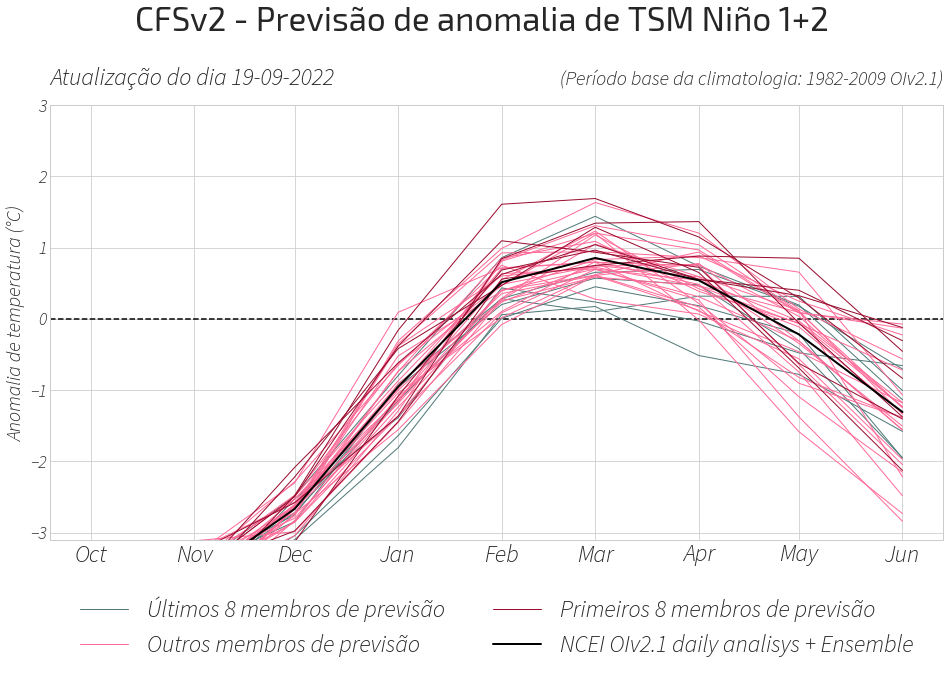

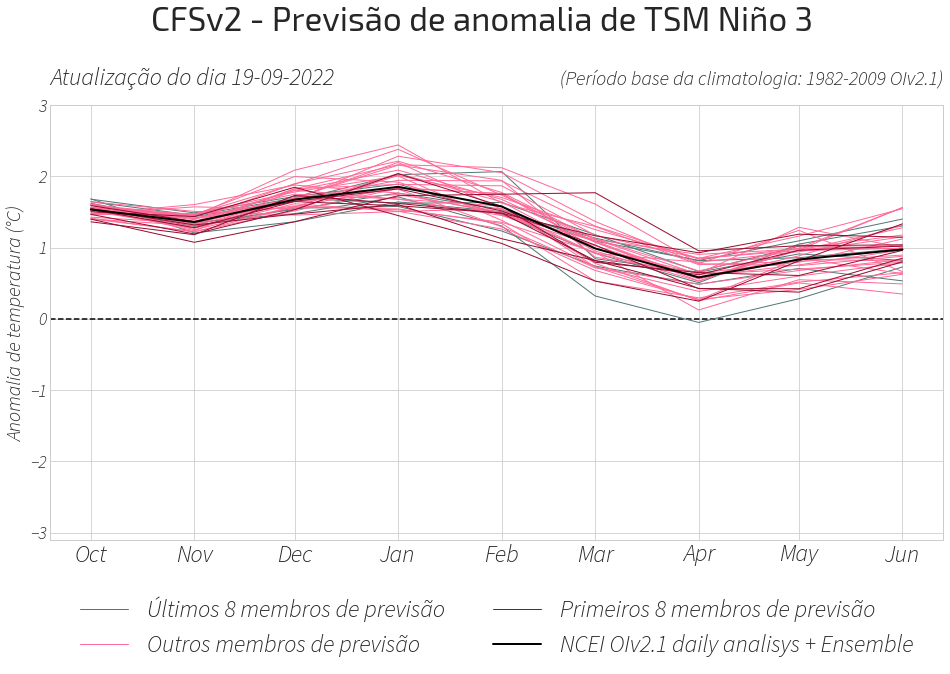

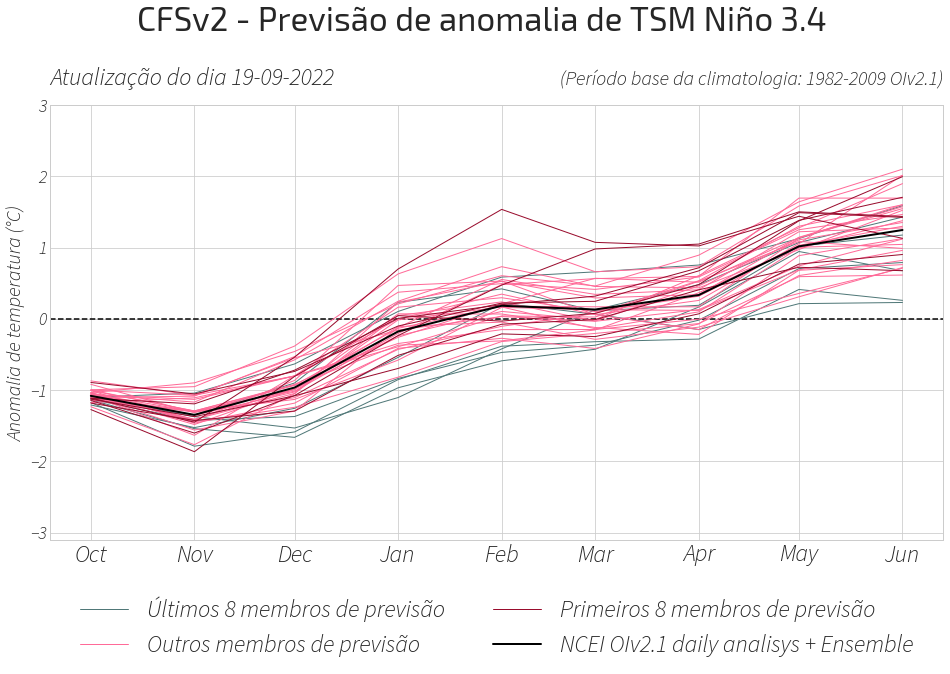

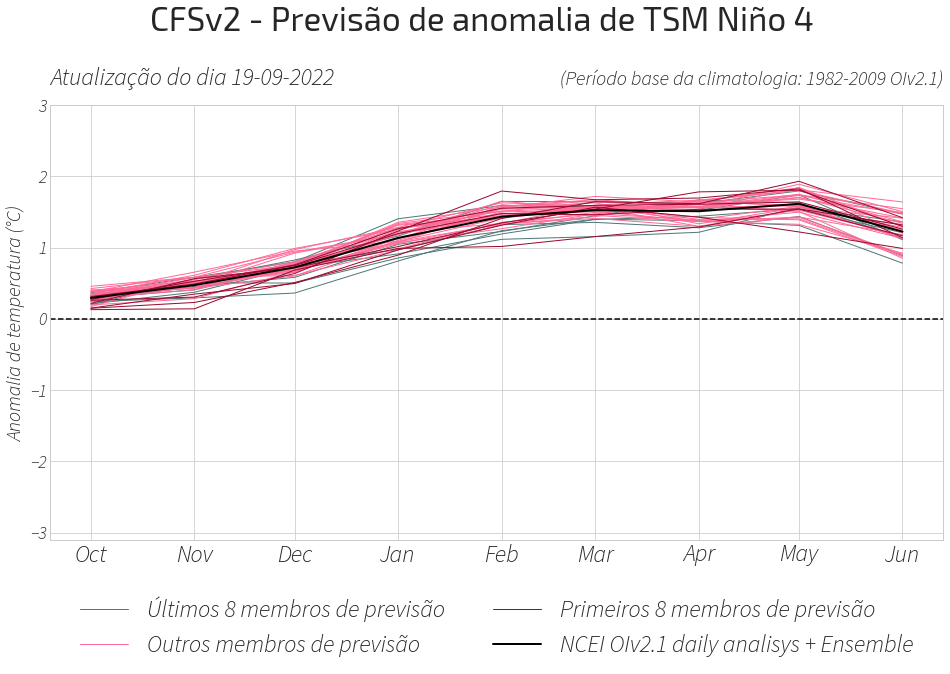

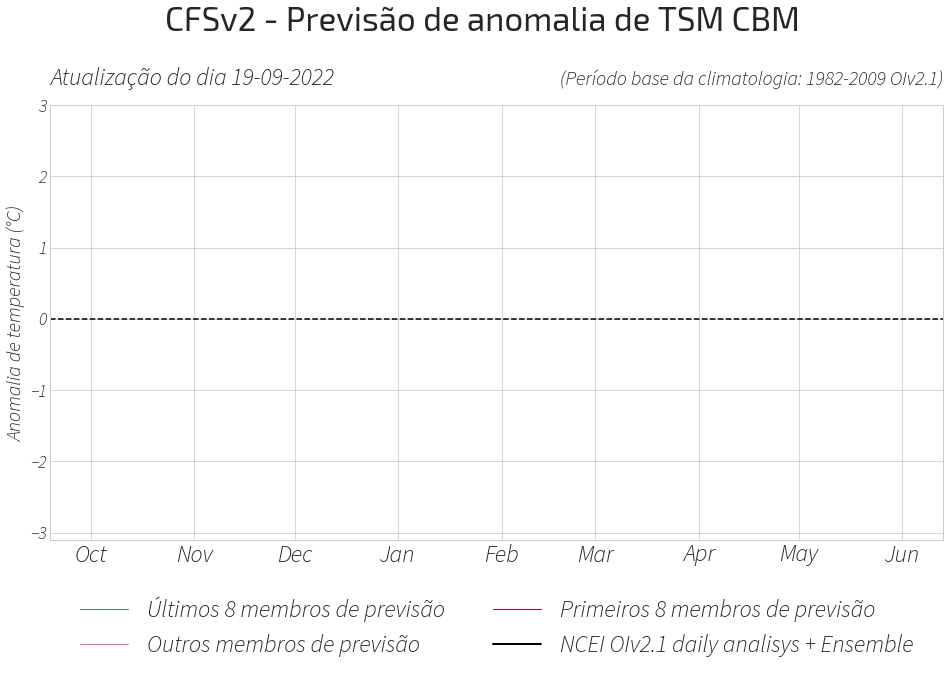

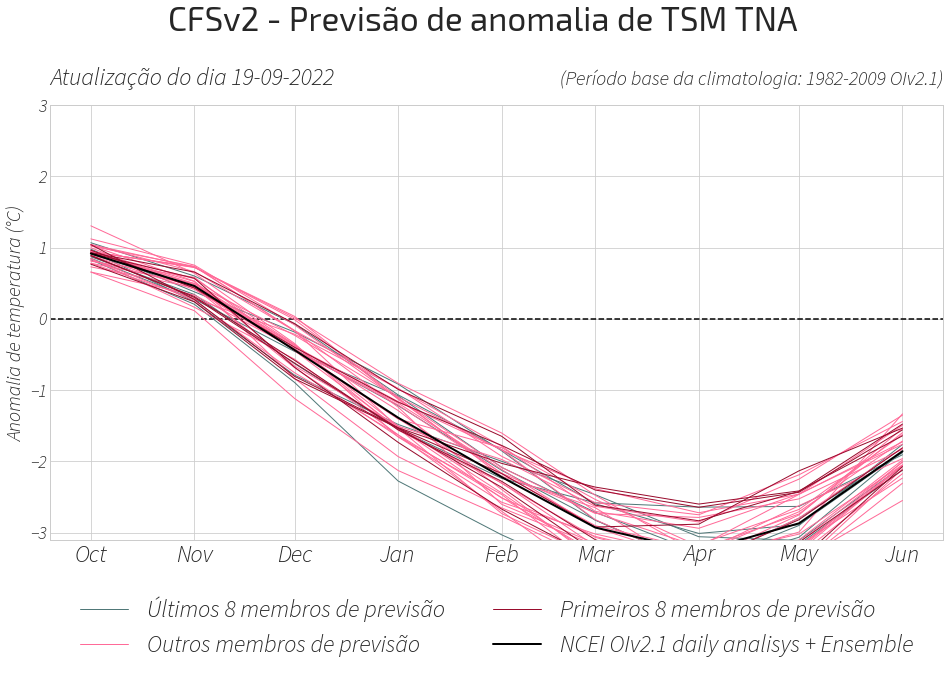

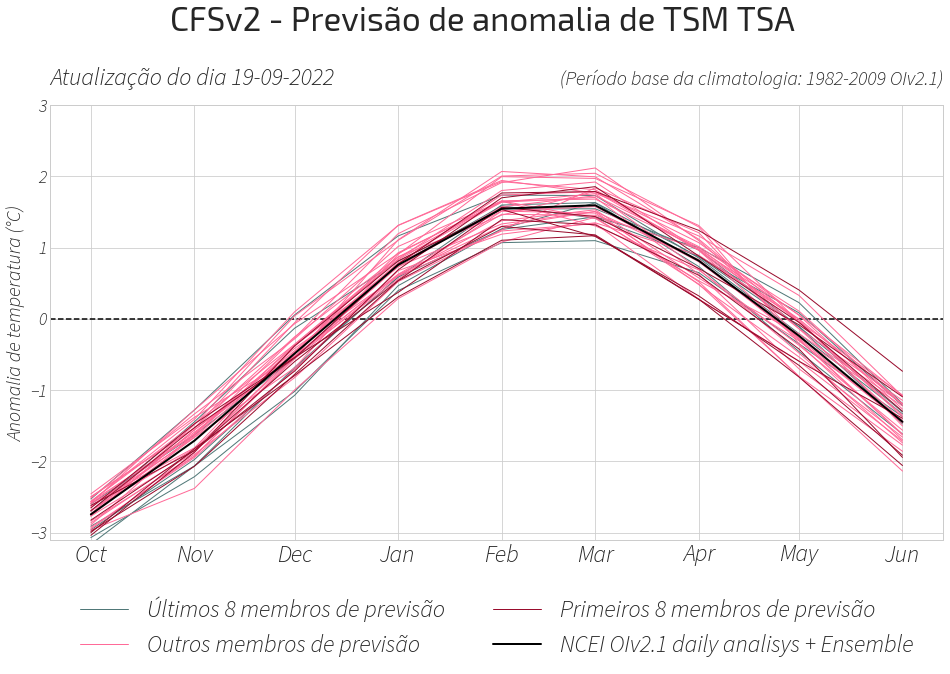

In [16]:
inicio = pendulum.datetime(2022,10,1)
fim = pendulum.datetime(2023, 6, 1)
periodo = pendulum.period(inicio, fim)

####################
## INICIO DO PLOT ##
####################
# Change the style of plot
plt.style.use('seaborn-v0_8-whitegrid')
fonte_titulo = Path('fonts', "Exo2-VariableFont_wght.ttf")
fonte_outros = Path('fonts', "SourceSansPro-LightItalic.ttf")
myfont1 = mpl.font_manager.FontProperties(fname=fonte_outros, size=24)
myFmt = mdates.DateFormatter('%b')

for indice in regioes:
    
    dict_nino_to_plot = {}
    outro_dict = {}
    for i in range(0,40):
        dict_nino_to_plot[i] = pd.DataFrame(columns=['time', 'anom']) #nino34
        outro_dict[i] = []
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.xaxis.set_major_formatter(myFmt)

    plt.suptitle(f'CFSv2 - Previsão de anomalia de {indice.nome}', font=fonte_titulo, fontsize=33, y=1.05)
    plt.title(f'Atualização do dia 19-09-2022', loc='left', font=fonte_outros, fontsize=24, pad=20)
    plt.title(f'(Período base da climatologia: {clima_texto})', loc='right', font=fonte_outros, fontsize=20, pad=20)
    plt.xticks(font=fonte_outros, fontsize=24)
    plt.yticks(font=fonte_outros, fontsize=18)
    plt.ylim(-3.1,3)
    plt.axhline(y=0, color='#000000', linestyle='--')

    ax.set_ylabel('Anomalia de temperatura (°C)', fontsize=20, font=fonte_outros)

    ###################
    # FOR NOS LEADS ###
    ###################
    for dt in periodo.range('months'):
        data_string = dt.format('YYYYMM')
        dt_df_format = f"{dt.format('YYYY-MM')}-01"
        mes_int = int(dt.format('MM'))

        dataset = le_grib_por_mes(data_string)
        anomalia_nino34 = recorte(dataset, mes_int, indice)

        for i in range(0,40):

            outro_dict[i].append([dt_df_format, anomalia_nino34[i].values])


    ###################
    # RETORNO DO PLOT #
    ###################
    contador = 0
    for i in range(39,0,-1):

        if contador in range(0,7):
            cor = "#507878" #'b'
            label = 'Últimos 8 membros de previsão'
        elif contador in range(32,40):
            cor= "#990C2D"#'r'
            label = 'Primeiros 8 membros de previsão'
        else:
            cor='#FF6A98'
            label = 'Outros membros de previsão'

        df2 = pd.DataFrame(outro_dict[i],
                           columns=['time', 'anom'])

        nino34c = pd.concat([dict_nino_to_plot[i], df2])
        dict_nino_to_plot[i] = nino34c

        indice_data = pd.to_datetime(nino34c.time, format='%Y.%m.%d')
        ax.plot(indice_data, dict_nino_to_plot[i].anom.values, cor, label=label, linewidth=1)

        contador = contador + 1

    ensemble = teste = pd.concat(list(dict_nino_to_plot.values()))
    ensemble = teste.groupby('time').mean()
    ax.plot(indice_data, ensemble, "#000000", linewidth=2, label='NCEI OIv2.1 daily analisys + Ensemble')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    plt.legend(by_label.values(), by_label.keys(), prop=myfont1, loc='center', ncols=2, bbox_to_anchor=(0.5, -0.2))
    fig.savefig(f'{indice.nome}.png', facecolor="white", bbox_inches="tight", dpi=300)

In [56]:
fig.savefig('b.png', facecolor="white", bbox_inches="tight", dpi=300)

# TESTE lendo todos os arquivos

In [14]:
arquivos = f'arquivos_teste_noaa/*.avrg.grib.grb2' # arquivos de monthly_grib_01 com nenhum ciclo no nome
    
dataset = xr.open_mfdataset(arquivos, concat_dim="valid_time", combine="nested",
                data_vars='minimal', coords='all', compat='override',
                backend_kwargs={
                    "filter_by_keys": {
                        "typeOfLevel": "surface",
                        "shortName": "t",
                    },
                 },
                parallel=True)

In [20]:
dataset.valid_time.values

array(['2022-10-10T00:00:00.000000000', '2022-11-09T00:00:00.000000000',
       '2022-12-09T00:00:00.000000000', '2023-01-08T00:00:00.000000000',
       '2023-02-07T00:00:00.000000000', '2023-03-09T00:00:00.000000000',
       '2023-04-08T00:00:00.000000000', '2023-05-08T00:00:00.000000000',
       '2023-06-07T00:00:00.000000000', '2023-07-07T00:00:00.000000000',
       '2022-10-10T06:00:00.000000000', '2022-11-09T06:00:00.000000000',
       '2022-12-09T06:00:00.000000000', '2023-01-08T06:00:00.000000000',
       '2023-02-07T06:00:00.000000000', '2023-03-09T06:00:00.000000000',
       '2023-04-08T06:00:00.000000000', '2023-05-08T06:00:00.000000000',
       '2023-06-07T06:00:00.000000000', '2023-07-07T06:00:00.000000000',
       '2022-10-10T12:00:00.000000000', '2022-11-09T12:00:00.000000000',
       '2022-12-09T12:00:00.000000000', '2023-01-08T12:00:00.000000000',
       '2023-02-07T12:00:00.000000000', '2023-03-09T12:00:00.000000000',
       '2023-04-08T12:00:00.000000000', '2023-05-08

In [22]:
#ds = dataset.groupby('time.year.month.day.hour').mean()

In [34]:
ds_ = dataset.groupby('valid_time.month').mean()

In [37]:
DS = dataset.groupby('valid_time.month').mean()

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, day: 10)
Coordinates:
  * latitude   (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * day        (day) int64 10 11 12 13 14 15 16 17 18 19
Data variables:
    t          (day, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [29]:
dataset.groupby(['valid_time.year', 'valid_time.month', 'valid_time.day','valid_time.hour']).mean()

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension. Received ['valid_time.year', 'valid_time.month', 'valid_time.day', 'valid_time.hour'] instead.